In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import yaml

from utils import load_experiment_dir

matplotlib.style.use('seaborn-notebook')
matplotlib.pyplot.rcParams['figure.figsize'] = (16, 10)
matplotlib.pyplot.rcParams['font.family'] = 'sans-serif'

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
%%time
two_headed_dir = "../exps/task1/two_headed_param_search/"

results = load_experiment_dir(two_headed_dir)

CPU times: user 26.4 s, sys: 188 ms, total: 26.6 s
Wall time: 29.1 s


# Fix hacks during development

In [183]:
results['early_stopping_strategy'] = results['early_stopping_strategy'].fillna('ratio')
results['epochs_run'] = results['train_loss'].apply(len)
results['speed'] = results['running_time'] / results['epochs_run']
results['share_embedding'] = results['share_embedding'].fillna(False)
results.loc[results['share_embedding'] == True, 'lemma_embedding_size'] = results.loc[results['share_embedding'] == True, 'inflected_embedding_size']

In [151]:
results['train_acc'] *= 100
results['dev_acc'] *= 100

### Languages

Filter all experiments except Breton, Latin and Lithuanian.

In [5]:
results = results[
    (results.language=='breton') |
    (results.language=='latin') |
    (results.language=='lithuanian')
]

# General stats

## Number of experiments

In [103]:
print("Number of experiments:", len(results))
print("Number of experiments by language:")
results.groupby('language').size().to_frame()

Number of experiments: 1886
Number of experiments by language:


,0
language,
breton,1033
latin,610
lithuanian,243


## Running time by language

In [104]:
results.groupby('language').running_time.describe()

,count,mean,std,min,25%,50%,75%,max
language,,,,,,,,
breton,1033.0,50.031884,33.923005,0.054207,29.978127,40.223412,59.188522,322.711144
latin,610.0,324.971852,232.741461,68.723583,178.215572,254.588905,387.729653,2195.468466
lithuanian,243.0,516.717488,394.132030,122.777172,292.252890,408.680755,607.979112,3921.219545


# Parameters changed across experiments

Not uniformly distributed

In [232]:
var_params = [
    'lemma_embedding_size',
    'lemma_hidden_size',
    'lemma_num_layers',

    'tag_embedding_size',
    'tag_hidden_size',
    'tag_num_layers',

    'inflected_embedding_size',
    'inflected_hidden_size',
    'inflected_num_layers',

    'dropout',
    'share_vocab',
]
var_params = sorted(var_params)

In [233]:
results[var_params].apply(pd.Series.value_counts).stack().swaplevel().to_frame().unstack().stack()

0
dropout                  0.1      563.0
                         0.3      561.0
                         0.4      558.0
                         0.6      204.0
inflected_embedding_size 10.0     369.0
                         20.0     644.0
                         30.0     620.0
                         50.0     253.0
inflected_hidden_size    128.0    553.0
                         256.0    549.0
                         512.0    593.0
                         1024.0   191.0
inflected_num_layers     1.0      933.0
                         2.0      953.0
lemma_embedding_size     10.0     366.0
                         20.0     630.0
                         30.0     636.0
                         50.0     254.0
lemma_hidden_size        128.0    559.0
                         256.0    559.0
                         512.0    564.0
                         1024.0   204.0
lemma_num_layers         1.0      639.0
                         2.0      667.0
                         3.0      282.0
                         4.0      298.0
share_vocab              False   1010.0
                         1.0      876.0
tag_embedding_size       5        648.0
                         10.0     598.0
                         20.0     640.0
tag_hidden_size          64       571.0
                         128.0    916.0
                         256.0    399.0
tag_num_layers           1.0      683.0
                         2.0      669.0
                         3.0      286.0
                         4.0      248.0

In [67]:
for param in var_params:
    if param == 'dropout':
        print("{} & {}\\\\".format(param, ", ".join(map(lambda s: str(float(s)), sorted(set(results[param].values))))))
    else:
        print("{} & {}\\\\".format(param, ", ".join(map(lambda s: str(int(s)), sorted(set(results[param].values))))))

dropout & 0.1, 0.3, 0.4, 0.6\\
inflected_embedding_size & 10, 20, 30, 50\\
inflected_hidden_size & 128, 256, 512, 1024\\
inflected_num_layers & 1, 2\\
lemma_embedding_size & 10, 20, 30, 50\\
lemma_hidden_size & 128, 256, 512, 1024\\
lemma_num_layers & 1, 2, 3, 4\\
share_vocab & 0, 1\\
tag_embedding_size & 5, 10, 20\\
tag_hidden_size & 64, 128, 256\\
tag_num_layers & 1, 2, 3, 4\\


In [96]:
r = results.groupby(var_params + ['language'])
r.filter(lambda x: len(x) >= 2).groupby(var_params + ['language']).dev_acc.describe()

count  \
dropout inflected_embedding_size inflected_hidden_size inflected_num_layers lemma_embedding_size lemma_hidden_size lemma_num_layers share_vocab tag_embedding_size tag_hidden_size tag_num_layers language            
0.1     10                       128                   2                    10                   512               3                False       20                 128             4              breton        2.0   
        20                       256                   2                    30                   1024              2                True        5                  256             2              breton        2.0   
        30                       512                   1                    20                   128               1                False       10                 64              4              latin         2.0   
0.3     20                       128                   2                    10                   512               3                False       5                  128             3              lithuanian    2.0   
0.4     20                       512                   1                    20                   512               2                True        10                 64              2              latin         2.0   
        30                       128                   1                    30                   512               2                True        5                  128             2              breton        2.0   

                                                                                                                                                                                                                mean  \
dropout inflected_embedding_size inflected_hidden_size inflected_num_layers lemma_embedding_size lemma_hidden_size lemma_num_layers share_vocab tag_embedding_size tag_hidden_size tag_num_layers language             
0.1     10                       128                   2                    10                   512               3                False       20                 128             4              breton      0.8550   
        20                       256                   2                    30                   1024              2                True        5                  256             2              breton      0.8650   
        30                       512                   1                    20                   128               1                False       10                 64              4              latin       0.6580   
0.3     20                       128                   2                    10                   512               3                False       5                  128             3              lithuanian  0.7785   
0.4     20                       512                   1                    20                   512               2                True        10                 64              2              latin       0.6865   
        30                       128                   1                    30                   512               2                True        5                  128             2              breton      0.8450   

                                                                                                                                                                                                                   std  \
dropout inflected_embedding_size inflected_hidden_size inflected_num_layers lemma_embedding_size lemma_hidden_size lemma_num_layers share_vocab tag_embedding_size tag_hidden_size tag_num_layers language               
0.1     10                       128                   2                    10                   512               3                False       20                 128             4              breton      0.007071   
        20                       256                   2                    30                   1024 

In [99]:
results.groupby('language').size()

language
breton        1033
latin          610
lithuanian     243
dtype: int64

In [105]:
results.groupby('inflected_embedding_size').dev_acc.describe()

,count,mean,std,min,25%,50%,75%,max
inflected_embedding_size,,,,,,,,
10,369.0,0.673507,0.233330,0.0,0.60600,0.7460,0.842,0.92
20,644.0,0.691155,0.234787,0.0,0.62675,0.7900,0.850,0.93
30,620.0,0.698076,0.226951,0.0,0.64175,0.7795,0.850,0.93
50,253.0,0.716798,0.226910,0.0,0.66100,0.8300,0.860,0.92


In [107]:
results.groupby('language').dev_acc.idxmax()

language
breton         308
latin         1405
lithuanian    1192
Name: dev_acc, dtype: int64

In [118]:
results.loc[results.groupby('language').dev_acc.idxmax()][var_params]

,dropout,inflected_embedding_size,inflected_hidden_size,inflected_num_layers,lemma_embedding_size,lemma_hidden_size,lemma_num_layers,share_vocab,tag_embedding_size,tag_hidden_size,tag_num_layers
308,0.6,20,1024,2,30,256,1,True,5,256,2
1405,0.3,20,512,2,30,512,4,False,20,128,4
1192,0.4,30,512,2,20,512,4,False,20,128,2


# Summary table-per-language

1. number of exps
2. max, mean dev acc (std?)
3. mean running time

In [168]:
s = results.groupby('language')[['dev_acc', 'running_time']].agg(['size', 'mean', 'max', 'std'])
s.running_time /= 60
s

dev_acc                             running_time            \
              size       mean   max        std         size      mean   
language                                                                
breton        1033  70.919652  93.0  28.702638    17.216667  0.833865   
latin          610  62.323934  78.9  11.295893    10.166667  5.416198   
lithuanian     243  80.250617  88.4   8.368745     4.050000  8.611958   

                                 
                  max       std  
language                         
breton       5.378519  0.565383  
latin       36.591141  3.879024  
lithuanian  65.353659  6.568867

In [212]:
s.iloc[:, [0, 1, 2, 3, 5]].T.round(2)

language            breton   latin  lithuanian
dev_acc      size  1033.00  610.00      243.00
             mean    70.92   62.32       80.25
             max     93.00   78.90       88.40
             std     28.70   11.30        8.37
running_time mean     0.83    5.42        8.61

In [234]:
print(s.iloc[:, [0, 1, 2, 3, 5]].T.round(2).to_latex())

\begin{tabular}{llrrr}
\toprule
        & language &   breton &   latin &  lithuanian \\
\midrule
dev\_acc & size &  1033.00 &  610.00 &      243.00 \\
        & mean &    70.92 &   62.32 &       80.25 \\
        & max &    93.00 &   78.90 &       88.40 \\
        & std &    28.70 &   11.30 &        8.37 \\
running\_time & mean &     0.83 &    5.42 &        8.61 \\
\bottomrule
\end{tabular}



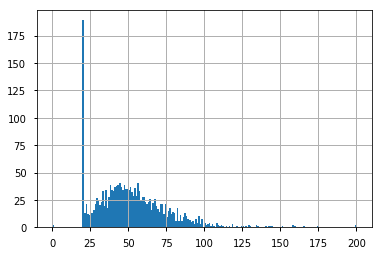

In [250]:
results['epochs_run'] = results.train_loss.apply(len)
results.epochs_run.hist(bins=200)

In [252]:
results.epochs_run.describe()

count    1886.000000
mean       51.402439
std        23.432589
min         0.000000
25%        35.000000
50%        49.000000
75%        64.000000
max       200.000000
Name: epochs_run, dtype: float64

In [256]:
(results.epochs_run > 100).mean()

0.02704135737009544

In [260]:
results.columns

Index(['batch_size', 'cell_type', 'commit_hash', 'dataset_class', 'defaults',
       'dev_acc', 'dev_file', 'dev_loss', 'dropout', 'early_stopping_ratio',
       'early_stopping_strategy', 'early_stopping_window', 'epochs',
       'experiment_dir', 'generate_empty_subdir', 'include_same_forms_ratio',
       'inflected_embedding_size', 'inflected_hidden_size',
       'inflected_num_layers', 'lemma_embedding_size', 'lemma_hidden_size',
       'lemma_num_layers', 'min_epochs', 'model', 'node', 'numpy_random_seed',
       'optimizer', 'optimizer_kwargs', 'overwrite_model', 'running_time',
       'save_attention_weights', 'save_min_epoch', 'share_context_encoder',
       'share_embedding', 'share_vocab', 'spaces', 'start_time',
       'tag_embedding_size', 'tag_hidden_size', 'tag_num_layers',
       'torch_random_seed', 'toy_eval', 'train_acc', 'train_file',
       'train_loss', 'use_eos', 'use_step', 'vocab_path_src', 'vocab_path_tgt',
       'language', 'min_dev_loss', 'min_train_loss', '

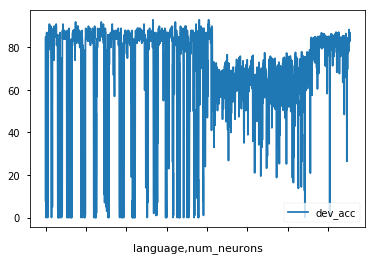

In [269]:
results['num_neurons'] = results.inflected_hidden_size * results.inflected_num_layers + \
    results.lemma_hidden_size * results.lemma_num_layers + \
    results.tag_hidden_size * results.tag_num_layers
    
results.sort_values(['language', 'num_neurons']).plot(x=['language', 'num_neurons'], y='dev_acc')

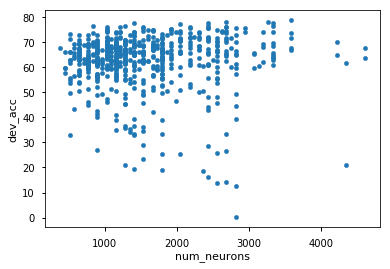

In [273]:
latin = results[results.language=='latin']
latin.sort_values('num_neurons').plot(x='num_neurons', y='dev_acc', kind='scatter')

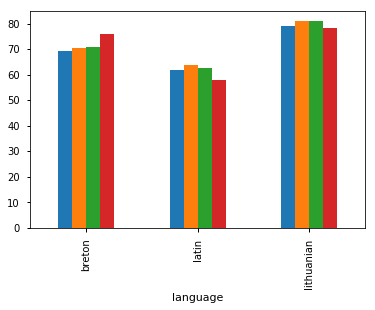

In [285]:
results.groupby(['language', 'dropout']).mean()['dev_acc'].unstack().plot(kind='bar', legend=False)

In [249]:
r = results.epochs_run.value_counts()
r.loc[20], r.loc[200]

(189, 2)

In [117]:
def save_n_best_config(results, n, save_dir, extra_params={}):
    """Saves N best configs by language"""
    best = results.loc[results.groupby('language').dev_acc.nlargest(n).unstack().columns][var_params + ['language']]
    for i, row in enumerate(best.iterrows()):
        as_dict = dict(row[1])
        if 'early_stopping_ratio' in as_dict:
            del as_dict['early_stopping_ratio']
        if 'language' in as_dict:
            as_dict['orig_language'] = as_dict['language']
            del as_dict['language']
        #as_dict['early_stopping_window'] = int(as_dict['early_stopping_window'])
        as_dict.update(extra_params)
        with open(os.path.join(save_dir, "config_{0:02d}.yaml".format(i)), 'w') as f:
            yaml.dump(as_dict, f, default_flow_style=False)
    
save_n_best_config(results[results.early_stopping_strategy=='dev_loss_increase'], 1,
                   "../config/task1/two_headed/best_config_single/",
                   extra_params={'experiment_dir': 'exps/task1/two_headed_best'})

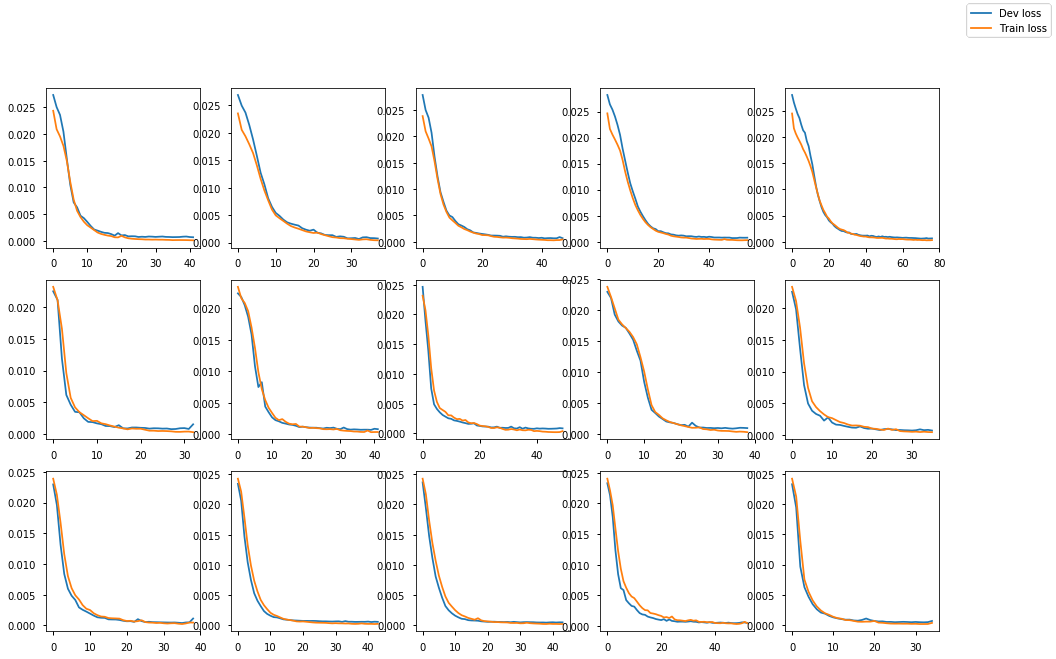

In [202]:
N = 5
M = len(results.groupby('language'))
best = results[results.early_stopping_strategy=='dev_loss_increase'].groupby('language').dev_acc.nlargest(N)
fig, ax = plt.subplots(M, N, figsize=(16, 10))
lang_map = {}
col_cnt = 0
for (lang, idx) in best.index:
    if lang not in lang_map:
        lang_map[lang] = len(lang_map)
        col_cnt = 0
    #fig.plot(results.loc[idx].dev_loss, ax=ax[lang_map[lang]][col_cnt])
    #plt.plot(results.loc[idx].dev_loss, ax=ax[lang_map[lang]][col_cnt])
    dev = ax[lang_map[lang]][col_cnt].plot(results.loc[idx].dev_loss)
    train = ax[lang_map[lang]][col_cnt].plot(results.loc[idx].train_loss)
    fig.legend(labels=['Dev loss', 'Train loss'])
    col_cnt += 1
    
#fig.legend( lines, labels, loc = (0.5, 0), ncol=5 )

# Variance

In [205]:
var_test = load_experiment_dir("../exps/task1/two_headed_variance_testing/")
var_test.head()

,batch_size,cell_type,commit_hash,dataset_class,defaults,dev_acc,dev_file,dev_loss,dropout,early_stopping_ratio,...,train_file,train_loss,use_eos,use_step,vocab_path_src,vocab_path_tgt,language,min_dev_loss,min_train_loss,train_size
0,128,LSTM,88a0cd8b5bd391b6cfaf16a9d7c6583efcf9795f,ReinflectionDataset,"{'cell_type': 'LSTM', 'dataset_class': 'Labele...",0.887,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.02279382586479187, 0.0185945086479187, 0.01...",0.4,1.5,...,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.023886621046066283, 0.021057239437103272, 0...",True,False,/mnt/permanent/home/judit/projects/sigmorphon2...,/mnt/permanent/home/judit/projects/sigmorphon2...,lithuanian,0.000414,0.000167,high
1,128,LSTM,88a0cd8b5bd391b6cfaf16a9d7c6583efcf9795f,ReinflectionDataset,"{'cell_type': 'LSTM', 'dataset_class': 'Labele...",0.690,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.023052839994430543, 0.0197501859664917, 0.0...",0.3,1.5,...,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.02314628508090973, 0.02095862147808075, 0.0...",True,False,/mnt/permanent/home/judit/projects/sigmorphon2...,/mnt/permanent/home/judit/projects/sigmorphon2...,latin,0.000958,0.000528,high
2,128,LSTM,88a0cd8b5bd391b6cfaf16a9d7c6583efcf9795f,ReinflectionDataset,"{'cell_type': 'LSTM', 'dataset_class': 'Labele...",0.900,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.027348487377166747, 0.025346713066101076, 0...",0.3,1.5,...,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.02429626256122291, 0.020993116222964472, 0....",True,False,/mnt/permanent/home/judit/projects/sigmorphon2...,/mnt/permanent/home/judit/projects/sigmorphon2...,breton,0.000843,0.000202,high
3,128,LSTM,88a0cd8b5bd391b6cfaf16a9d7c6583efcf9795f,ReinflectionDataset,"{'cell_type': 'LSTM', 'dataset_class': 'Labele...",0.880,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.027159481048583983, 0.02536638021469116, 0....",0.3,1.5,...,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.024239362518533696, 0.020897534539227047, 0...",True,False,/mnt/permanent/home/judit/projects/sigmorphon2...,/mnt/permanent/home/judit/projects/sigmorphon2...,breton,0.000768,0.000210,high
4,128,LSTM,88a0cd8b5bd391b6cfaf16a9d7c6583efcf9795f,ReinflectionDataset,"{'cell_type': 'LSTM', 'dataset_class': 'Labele...",0.771,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.0221556978225708, 0.01840983557701111, 0.01...",0.3,1.5,...,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.023142023921012878, 0.020096067953109743, 0...",True,False,/mnt/permanent/home/judit/projects/sigmorphon2...,/mnt/permanent/home/judit/projects/sigmorphon2...,latin,0.000725,0.000397,high


In [206]:
var_test.train_acc *= 100
var_test.dev_acc *= 100

In [209]:
var_test.groupby('language')[['train_acc', 'dev_acc']].agg(['mean', 'std', 'min', 'max']).T.round(2)

language        breton  latin  lithuanian
train_acc mean   96.29  92.58       96.69
          std     1.39   3.21        2.25
          min    94.30  84.57       90.51
          max    99.04  97.14       99.08
dev_acc   mean   87.35  74.73       86.95
          std     2.41   3.17        2.32
          min    84.00  69.00       81.80
          max    92.00  79.10       90.60

In [213]:
print(var_test.groupby('language')[['train_acc', 'dev_acc']].agg(['mean', 'std', 'min', 'max']).T.round(2).to_latex())

\begin{tabular}{llrrr}
\toprule
          & language &  breton &  latin &  lithuanian \\
\midrule
train\_acc & mean &   96.29 &  92.58 &       96.69 \\
          & std &    1.39 &   3.21 &        2.25 \\
          & min &   94.30 &  84.57 &       90.51 \\
          & max &   99.04 &  97.14 &       99.08 \\
dev\_acc & mean &   87.35 &  74.73 &       86.95 \\
          & std &    2.41 &   3.17 &        2.32 \\
          & min &   84.00 &  69.00 &       81.80 \\
          & max &   92.00 &  79.10 &       90.60 \\
\bottomrule
\end{tabular}



# Luong vs Two-headed

In [216]:
%%time
comp = pd.concat((
    load_experiment_dir("../exps/task1/luong_new/"),
    load_experiment_dir("../exps/task1/two_headed/"),
))
comp.shape

CPU times: user 16.9 s, sys: 40 ms, total: 17 s
Wall time: 17.5 s


In [254]:
comp.groupby(['model', 'train_size']).describe()

batch_size                                   \
                                      count   mean  std    min    25%    50%   
model                 train_size                                               
LuongAttentionSeq2seq high            172.0  128.0  0.0  128.0  128.0  128.0   
                      low             208.0  128.0  0.0  128.0  128.0  128.0   
                      medium          205.0  128.0  0.0  128.0  128.0  128.0   
ReinflectionSeq2seq   high             87.0  128.0  0.0  128.0  128.0  128.0   
                      low             103.0  128.0  0.0  128.0  128.0  128.0   
                      medium          102.0  128.0  0.0  128.0  128.0  128.0   

                                               dev_acc              ...     \
                                    75%    max   count      mean    ...      
model                 train_size                                    ...      
LuongAttentionSeq2seq high        128.0  128.0   172.0  0.900017    ...      
                      low         128.0  128.0   208.0  0.000841    ...      
                      medium      128.0  128.0   205.0  0.456424    ...      
ReinflectionSeq2seq   high        128.0  128.0    87.0  0.784517    ...      
                      low         128.0  128.0   103.0  0.001922    ...      
                      medium      128.0  128.0   102.0  0.239118    ...      

                                 torch_random_seed               train_acc  \
                                               75%           max     count   
model                 train_size                                             
LuongAttentionSeq2seq high            1.598963e+09  2.130806e+09     172.0   
                      low             1.595717e+09  2.142556e+09     208.0   
                      medium          1.562906e+09  2.145724e+09     205.0   
ReinflectionSeq2seq   high            1.685372e+09  2.128796e+09      87.0   
                      low             1.612466e+09  2.116330e+09     103.0   
                      medium          1.690622e+09  2.143107e+09     102.0   

                                                                          \
                                      mean       std       min       25%   
model                 train_size                                           
LuongAttentionSeq2seq high        0.933029  0.075088  0.574333  0.908200   
                      low         0.001788  0.008047  0.000000  0.000000   
                      medium      0.563279  0.332992  0.000000  0.321000   
ReinflectionSeq2seq   high        0.847549  0.193279  0.002200  0.822732   
                      low         0.013716  0.027134  0.000000  0.000000   
                      medium      0.348625  0.346216  0.000000  0.044500   

                                                              
                                     50%       75%       max  
model                 train_size                              
LuongAttentionSeq2seq high        0.9512  0.985281  1.000000  
                      low         0.0000  0.000000  0.065574  
                      medium      0.6630  0.842000  1.000000  
ReinflectionSeq2seq   high        0.9141  0.981546  1.000000  
                      low         0.0000  0.010000  0.140000  
                      medium      0.1930  0.648000  1.000000  

[6 rows x 224 columns]

In [226]:
comp[comp.model=='LuongAttentionSeq2seq']

,batch_size,cell_type,commit_hash,dataset_class,defaults,dev_acc,dev_file,dev_loss,dropout,early_stopping_ratio,...,torch_random_seed,toy_eval,train_acc,train_file,train_loss,train_size,use_eos,use_step,vocab_path_src,vocab_path_tgt
0,128,LSTM,5313764e08f3c5467434365181552dd7cab9806e,SIGMORPOHTask1Dataset,"{'cell_type': 'LSTM', 'dataset_class': 'Labele...",0.950,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.02184716486930847, 0.020564398765563964, 0....",0.3,1.5,...,366992402,None,0.973900,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.024677814388275147, 0.021085854721069337, 0...",high,True,False,/mnt/permanent/home/judit/projects/sigmorphon2...,/mnt/permanent/home/judit/projects/sigmorphon2...
1,128,LSTM,5313764e08f3c5467434365181552dd7cab9806e,SIGMORPOHTask1Dataset,"{'cell_type': 'LSTM', 'dataset_class': 'Labele...",0.000,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.02813663625717163, 0.028031569480895996, 0....",0.3,1.5,...,2108901883,None,0.000000,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.03530671119689941, 0.03517246007919311, 0.0...",low,True,False,/mnt/permanent/home/judit/projects/sigmorphon2...,/mnt/permanent/home/judit/projects/sigmorphon2...
2,128,LSTM,5313764e08f3c5467434365181552dd7cab9806e,SIGMORPOHTask1Dataset,"{'cell_type': 'LSTM', 'dataset_class': 'Labele...",0.670,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.030279311895370482, 0.02802010488510132, 0....",0.3,1.5,...,977004769,None,0.853000,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.030855388879776, 0.029458749055862425, 0.02...",medium,True,False,/mnt/permanent/home/judit/projects/sigmorphon2...,/mnt/permanent/home/judit/projects/sigmorphon2...
3,128,LSTM,5313764e08f3c5467434365181552dd7cab9806e,SIGMORPOHTask1Dataset,"{'cell_type': 'LSTM', 'dataset_class': 'Labele...",0.929,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.022686552047729493, 0.021332940578460694, 0...",0.3,1.5,...,103156326,None,0.943100,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.02556199870109558, 0.02185531313419342, 0.0...",high,True,False,/mnt/permanent/home/judit/projects/sigmorphon2...,/mnt/permanent/home/judit/projects/sigmorphon2...
4,128,LSTM,5313764e08f3c5467434365181552dd7cab9806e,SIGMORPOHTask1Dataset,"{'cell_type': 'LSTM', 'dataset_class': 'Labele...",0.001,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.02843864107131958, 0.02833994650840759, 0.0...",0.3,1.5,...,197898677,None,0.000000,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.0356751012802124, 0.035554609298706054, 0.0...",low,True,False,/mnt/permanent/home/judit/projects/sigmorphon2...,/mnt/permanent/home/judit/projects/sigmorphon2...
5,128,LSTM,5313764e08f3c5467434365181552dd7cab9806e,SIGMORPOHTask1Dataset,"{'cell_type': 'LSTM', 'dataset_class': 'Labele...",0.791,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.02987474036216736, 0.027700435161590577, 0....",0.3,1.5,...,1554764766,None,0.859000,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.03044654154777527, 0.029097753524780272, 0....",medium,True,False,/mnt/permanent/home/judit/projects/sigmorphon2...,/mnt/permanent/home/judit/projects/sigmorphon2...
6,128,LSTM,5313764e08f3c5467434365181552dd7cab9806e,SIGMORPOHTask1Dataset,"{'cell_type': 'LSTM', 'dataset_class': 'Labele...",0.831,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.022069135665893556, 0.020900786638259887, 0...",0.3,1.5,...,1569583246,None,0.890300,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.024325974607467653, 0.021286179637908936, 0...",high,True,False,/mnt/permanent/home/judit/projects/sigmorphon2...,/mnt/permanent/home/judit/projects/sigmorphon2...
7,128,LSTM,5313764e08f3c5467434365181552dd7cab9806e,SIGMORPOHTask1Dataset,"{'cell_type': 'LSTM', 'dataset_class': 'Labele...",0.000,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.028954597473144533, 0.028860272884368897, 0...",0.3,1.5,...,1314762733,None,0.000000,/mnt/permanent/home/judit/projects/sigmorphon2...,"[0.036304643154144285, 0